In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time

In [2]:

class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 1, input_layer = False, mod = True):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        
            
        self.input_layer = input_layer
        self.fc = nn.Linear(n_in,n_out,bias = False)
        

    def forward(self, x):
        if not self.input_layer:
            x = self.fc(x)
                
        if x.shape != self.potentials.shape:
            raise Exception("Size mismatch {} x {}".format(x.shape,self.potentials.shape))
        x = x.unsqueeze(-1)
        
        #calculate potential change
        delta_p =  torch.sum(x,-1)#torch.sum(self.func_int(x),-1)
        self.potentials = Parameter(self.potentials + delta_p)
        
        #generate spikes
        spikes = (self.potentials > self.thresh).float()
        
        if self.mod:
            #After spike overflow is kept
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            #After spike potential is set to zero removing any overlow
            self.potentials = Parameter(self.potentials * (1 - spikes))

        
        return spikes, (self.potentials + spikes)
    
class Net(nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        self.spike1 = Spike1d(2,2, input_layer = True, mod = False, thresh = 0)
        self.spike2 = Spike1d(2,1, mod = mod)
        #self.spike3 = Spike1d(5,2)
    def forward(self, x):
        spikes = []
        x, pots = self.spike1(x)
        #print(pots)
        spikes.append(pots.detach().numpy())
       
        #x = self.fc1(x)
        x, pots = self.spike2(x)
        spikes.append(pots.detach().numpy())
        #print(x)
       # print()
        
        #x = self.fc2(x)#.unsqueeze(-1)
        #x,pot = self.spike3(x)
        #spikes.append(pot.detach().numpy())
       # print(x)
        
        return x, spikes


<IPython.core.display.Javascript object>


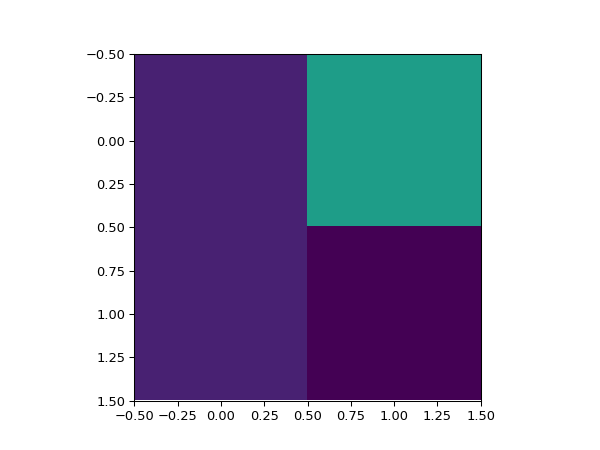

In [3]:
model = Net(mod = False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

def draw_spikes(spikes, ax):
    l_dim = 0
    for i in spikes:
        if i.shape[0] > l_dim:
            l_dim = i.shape[0]
         
    spikes_ = torch.zeros(len(spikes),l_dim) - 0.1
    
    
    for i in range(len(spikes)):
        spikes_[i][0:spikes[i].shape[0]] = torch.tensor(spikes[i])
        
    spikes_ = spikes_.t()
    
    ax.clear()
    ax.imshow(spikes_,vmin=-0.1, vmax=1)
    

x_fire = np.array(random.sample(range(1,150), 15))
y_fire = x_fire + 2

for e in range(150):
    in_spike = torch.tensor([e in x_fire,e in y_fire], dtype=torch.float)
    #print(in_spike)
    #out,spikes = model(torch.tensor([0.5]*2, dtype=torch.float))#torch.randn(1, dtype=torch.float))
    
    out,spikes = model(in_spike)#torch.randn(1, dtype=torch.float))
    #print(in_spike)
    draw_spikes(spikes, ax)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_spike.data))
    fig.canvas.draw()
    time.sleep(0.1)

In [4]:

#model = Net()

for param in model.parameters():
    print("")
    print(param.data)
    
print("done")


tensor([0., 0.])

tensor([[ 0.4750,  0.1389],
        [-0.1306,  0.3851]])

tensor([0.5130])

tensor([[-0.1349,  0.2375]])
done


In [5]:
test = torch.zeros([5,5])
print(test)
test[2][[1,2,3]] = 1
print(test)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [6]:
import numpy as np

In [7]:
b = torch.zeros([5])
a = torch.ones([3])

b[0:a.shape[0]] = a
print(b)

tensor([1., 1., 1., 0., 0.])
